# Making our Models
We will create four different models: feedforward, RNN, LSTM, and an LSTM with attention

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Importing utility functions from Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import SimpleRNN, Dense, LSTM, Flatten
from keras.layers import Input, Dense, LSTM, Attention, Concatenate

from utils import convertSamplesToEmbeddings, read_embeddings, generate_ngram_training_samples, data_generator

In [25]:
N_GRAM = 5
EMBEDDING_SIZE = 100
BATCH_SIZE = 1000
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PROCESSED_DATA_FILE = "../data/processed/processed_data.csv"
STANZAS_FILE = '../data/processed/stanzas.txt'
EMBEDDING_FILE = "../reference-materials/lyrics_embeddings.txt"

In [26]:
new_stanzas_as_words = []
with open(STANZAS_FILE, 'r', encoding='utf-8') as txtfile:
    for line in txtfile:
        # Split each line into a list using '\t' as the separator
        line_data = line.strip().split('\t')
        new_stanzas_as_words.append(line_data)

### Create list of song lyrics with genre
Tokenizes the each song into a a list of sentences. Appends the genre of the song in front of each 
sentence.

In [27]:
# Initialize a Tokenizer and fit on your data
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(new_stanzas_as_words)
# Convert stanzas into numerical indexes (list of lists of string -> list of lists of int)
stanzas = tokenizer.texts_to_sequences(new_stanzas_as_words)

In [28]:
# print size of vocab
vocab_size = len(tokenizer.word_counts)
print("Vocab size: ", vocab_size)

Vocab size:  87923


### Read in the embeddings and create dictionary mapping index to embeddings

In [29]:
index_to_embedding = read_embeddings(EMBEDDING_FILE, tokenizer)

### Create ngram training samples
Add each genre to the beginning of the ngram. The ngram is of size 5, index 0 is the genre. Indexes
1-3 are the features, and index 5 is the label

In [30]:
X, y = generate_ngram_training_samples(stanzas, N_GRAM)

In [31]:
print("Number of training samples: ", len(X))
print("Number of labels: ", len(y))
print("First training sample: ", X[0])
print("First label: ", y[0])
print("Second training sample: ", X[1])
print("Second label: ", y[1])

Number of training samples:  14990276
Number of labels:  14990276
First training sample:  [530, 13, 13, 13]
First label:  541
Second training sample:  [530, 13, 13, 541]
Second label:  11


### Split the Data

In [32]:
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

## Creating Models


### Create RNN models. We will use the RNN model in order to find the best number of units to use

In [41]:
def build_rnn_model(X, y, index_to_embedding: dict, batch_size=4, sequence_length=N_GRAM, epochs=1, units=16):
    generator = data_generator(X, y, index_to_embedding, batch_size, sequence_length, epochs)
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(sequence_length-1, EMBEDDING_SIZE), activation='relu'))
    model.add(Dense(len(index_to_embedding), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x=generator, steps_per_epoch=len(X) // batch_size, epochs=epochs)
    model.save('../models/rnn_model_' + str(units) + '_units.h5')
    #training_loss_history = history.history['loss']
    # plt.plot(training_loss_history)
    # plt.xlabel('Epoch')
    # plt.ylabel('Training Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.show()

    return model, history

#### Use 2, 4, 8, 16, and 32 units

In [53]:
rnn_model_2_units, rnn_history_2_units =  build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=2)

10493/10493 [==============================] - 2096s 200ms/step - loss: 4.1097 - accuracy: 0.1842


In [46]:
rnn_model_4_units, rnn_history_4_units =  build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=4)

10493/10493 [==============================] - 2302s 219ms/step - loss: 3.2256 - accuracy: 0.2990


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
rnn_model_8_units, rnn_history_8_units =  build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=8)

10493/10493 [==============================] - 2095s 200ms/step - loss: 1.9545 - accuracy: 0.5668


In [47]:
rnn_model_16_units, rnn_history_16_units =  build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=16)

10493/10493 [==============================] - 2249s 214ms/step - loss: 0.9327 - accuracy: 0.8180


In [50]:
rnn_model_32_units, rnn_history_32_units = build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=32)

10493/10493 [==============================] - 2231s 212ms/step - loss: 0.3819 - accuracy: 0.9158


In [49]:
rnn_model_64_units, rnn_history_64_units = build_rnn_model(X_train, y_train, index_to_embedding, batch_size=BATCH_SIZE, sequence_length=N_GRAM, epochs=1, units=64)

10493/10493 [==============================] - 2237s 213ms/step - loss: 0.2471 - accuracy: 0.9281


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


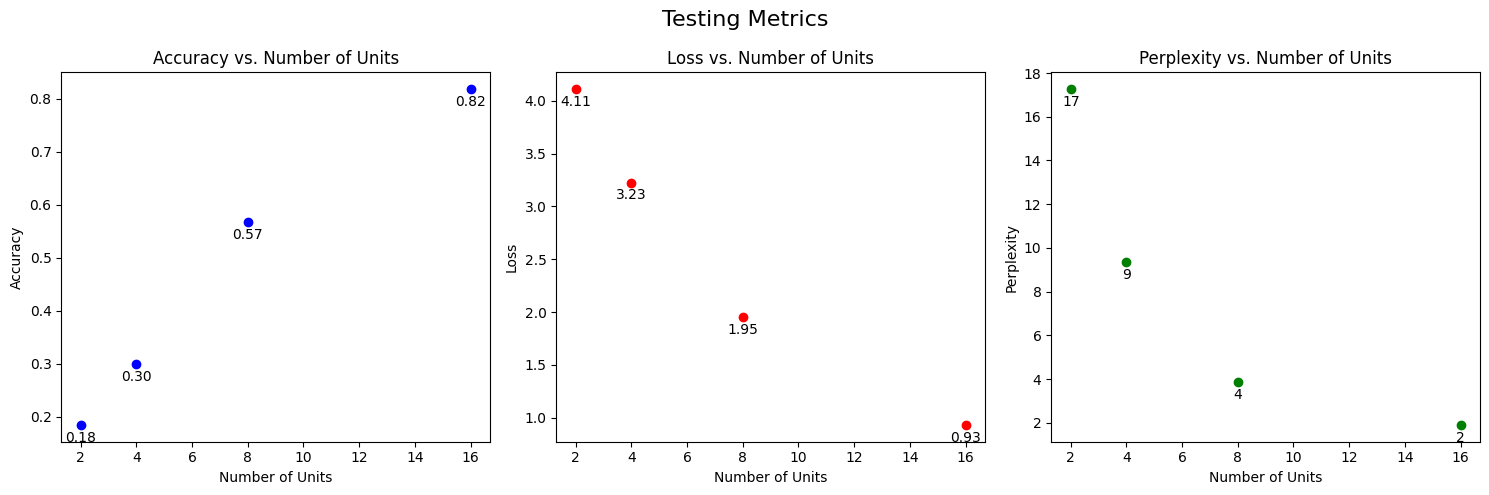

In [69]:
accuracies = [rnn_history_2_units.history['accuracy'][-1], rnn_history_4_units.history['accuracy'][-1], rnn_history_8_units.history['accuracy'][-1], rnn_history_16_units.history['accuracy'][-1]]
losses = [rnn_history_2_units.history['loss'][-1], rnn_history_4_units.history['loss'][-1], rnn_history_8_units.history['loss'][-1], rnn_history_16_units.history['loss'][-1]]
perplexities = [np.power(2, loss) for loss in losses]
units = [2, 4, 8, 16]

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Accuracy vs. Number of Units
axs[0].scatter(units, accuracies, color='blue')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Number of Units')
axs[0].set_title('Accuracy vs. Number of Units')

# Annotate each point with its accuracy value
for i, txt in enumerate(accuracies):
    axs[0].annotate(f'{accuracies[i]:.2f}', (units[i], accuracies[i]), textcoords="offset points", xytext=(0,-12), ha='center')

# Plot Loss vs. Number of Units
axs[1].scatter(units, losses, color='red')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Number of Units')
axs[1].set_title('Loss vs. Number of Units')

# Annotate each point with its accuracy value
for i, txt in enumerate(losses):
    axs[1].annotate(f'{losses[i]:.2f}', (units[i], losses[i]), textcoords="offset points", xytext=(0,-12), ha='center')

# Plot Perplexity vs. Number of Units
axs[2].scatter(units, perplexities, color='green')
axs[2].set_ylabel('Perplexity')
axs[2].set_xlabel('Number of Units')
axs[2].set_title('Perplexity vs. Number of Units')


# Annotate each point with its accuracy value
for i, txt in enumerate(perplexities):
    axs[2].annotate(f'{perplexities[i]:.0f}', (units[i], perplexities[i]), textcoords="offset points", xytext=(0,-12), ha='center')

# Set a general title for the entire plot
fig.suptitle('Testing Metrics', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

### Create Feedforward model with _ units 

In [59]:
def build_feed_forward_model(X, y, index_to_embedding: dict, batch_size=1000, sequence_length=N_GRAM, epochs=1, units=16):
  generator = data_generator(X, y, index_to_embedding, batch_size, sequence_length, epochs)
  model = Sequential()
  # Flatten the input sequence to be compatible with Dense layers
  model.add(Flatten(input_shape=(sequence_length-1, EMBEDDING_SIZE)))
  # Add one or more Dense layers
  model.add(Dense(units, activation='relu'))
  model.add(Dense(units=len(index_to_embedding), activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.save('../models/feed_forward_model.keras')
  history = model.fit(x=generator, steps_per_epoch=len(X) // batch_size, epochs=epochs)
  # training_loss_history = history.history['loss']
  # plt.plot(training_loss_history)
  # plt.xlabel('Epoch')
  # plt.ylabel('Training Loss')
  # plt.title('Training Loss Over Epochs')
  # plt.show()

  
  return model, history

In [60]:
feed_forward_model, feed_forward_history = build_feed_forward_model(X_train, y_train, index_to_embedding, batch_size=1000, sequence_length=N_GRAM, epochs=1, units=2)

10493/10493 [==============================] - 1915s 182ms/step - loss: 4.0369 - accuracy: 0.1893


### Create LSTM model with _ units

In [70]:
def build_lstm_model(X, y, index_to_embedding: dict, batch_size=4, sequence_length=N_GRAM, epochs=1,units=16):
    generator = data_generator(X, y, index_to_embedding, batch_size, sequence_length, epochs)
    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length-1, EMBEDDING_SIZE), activation='relu'))
    model.add(Dense(len(index_to_embedding), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x=generator, steps_per_epoch=len(X) // batch_size, epochs=epochs)
    model.save('../models/lstm_model.h5')
    # training_loss_history = history.history['loss']
    # plt.plot(training_loss_history)
    # plt.xlabel('Epoch')
    # plt.ylabel('Training Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.show()
    return model, history

In [71]:
lstm_model, lstm_history = build_lstm_model(X_train, y_train, index_to_embedding, batch_size=1000, sequence_length=N_GRAM, epochs=1, units=2)

10493/10493 [==============================] - 2536s 242ms/step - loss: 4.1703 - accuracy: 0.2012


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### LSTM Model with Attention

In [57]:
def build_attention_lstm_model(X, y, index_to_embedding: dict, batch_size=4, sequence_length=N_GRAM, epochs=1, units=16):
    generator = data_generator(X, y, index_to_embedding, batch_size, sequence_length, epochs)
    # Input layer
    inputs = Input(shape=(sequence_length-1, EMBEDDING_SIZE))
    lstm_out = LSTM(units, activation='relu')(inputs)
    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])
    # Concatenate the LSTM output and the attention output
    merged = Concatenate(axis=-1)([lstm_out, attention])
    # Flatten the input
    flattened = Flatten()(merged)
    # Dense layer for classification
    output = Dense(len(index_to_embedding), activation='softmax')(flattened)
    # Build the model
    model = Model(inputs=inputs, outputs=output)
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    history = model.fit(x=generator, steps_per_epoch=len(X) // batch_size, epochs=epochs)
    # Save the model
    model.save('../models/attention_lstm_model.h5')
    # training_loss_history = history.history['loss']
    # plt.plot(training_loss_history)
    # plt.xlabel('Epoch')
    # plt.ylabel('Training Loss')
    # plt.title('Training Loss Over Epochs')
    # plt.show()

    return model, history

In [58]:
attention_lstm_model, attention_lstm_history = build_attention_lstm_model(X_train, y_train, index_to_embedding, batch_size=1000, sequence_length=N_GRAM, epochs=1, units=2)

10493/10493 [==============================] - 2193s 209ms/step - loss: 3.4914 - accuracy: 0.2306
